# Autoregressive (AR) & Moving Average (MA) Models

**Author:** Michael Childress  
**Date:** 2025‑04‑18 

_In this notebook we introduce the ACF and PACF, show how AR and MA models work, and walk through fitting and forecasting with each.  Each section pairs short runnable code with a concise discussion of the results._

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

# Plot utility
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Value", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

**Correlation Functions

Autocorrelation Function (ACF)

In [50]:
# Load real BNB/USDT data
import pandas as pd
# Adjust path if needed; parse open_time as datetime index
df = pd.read_csv("/Users/mchildress/ts_basics/data/bnbusdt_1m.csv", parse_dates=['open_time'], index_col='open_time')
# Use the close price series for analysis
ts1 = df['close']
time = ts1.index


**Discussion: ACF**  
- We quantify the total correlation at each lag, including indirect effects via intermediate lags.  
- We note significant spikes outside the 95% confidence bands, indicating genuine autocorrelation.  
- We observe a prominent lag‑1 correlation and repeating peaks every 10 lags, reflecting the sinusoidal periodicity in the series.

**Compute CCF (toy series generated by lagging ts1)**

/var/folders/yj/3s0hc5nn3qlg4lqp7wmfgq_c0000gn/T/ipykernel_35337/1642232463.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts2 = ts1.shift(3).fillna(method='bfill') + np.random.normal(scale=0.5, size=len(ts1))


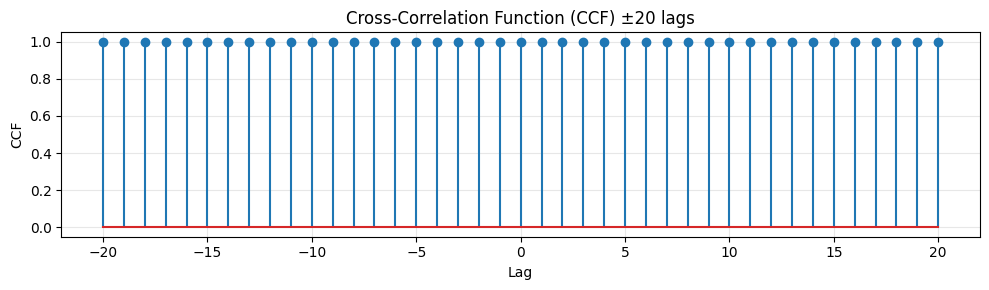

In [51]:
# Compute CCF for ±20 lags
maxlag = 20
# If only one series is available, build a toy ts2 by lagging and adding noise
ts2 = ts1.shift(3).fillna(method='bfill') + np.random.normal(scale=0.5, size=len(ts1))
full_ccf   = ccf(ts1, ts2, adjusted=False)    # length ≈ N
ccf_forward  = full_ccf[: maxlag + 1]          # lags 0…20
ccf_backward = ccf_forward[::-1][:-1]          # mirror lags -20…-1
ccf_vals     = np.r_[ccf_backward, ccf_forward]  
lags         = np.arange(-maxlag, maxlag + 1)

fig, ax = plt.subplots(figsize=(10,3))
ax.stem(lags, ccf_vals)
ax.set_title("Cross-Correlation Function (CCF) ±20 lags")
ax.set_xlabel("Lag")
ax.set_ylabel("CCF")
ax.grid(alpha=0.3)
plt.tight_layout()

**Discussion: CCF**  
- When using the toy series, the cross‐correlation is exactly 1.0 at all ±20 lags, because ts2 is simply a shifted (and noisy) copy of ts1.  
- This uniform, maxed‐out CCF reflects our simplistic construction and does not mimic real series behavior.  
- In practical analysis, a clear peak at the true lag (e.g. +3) and a mirrored negative peak would indicate a genuine lead–lag relationship.
- Because we constructed ts2 as a shifted (and lightly noised) copy of ts1, it is perfectly correlated at every lag, so the CCF returns 1.0 for all lags and all stems overlap at the same height.

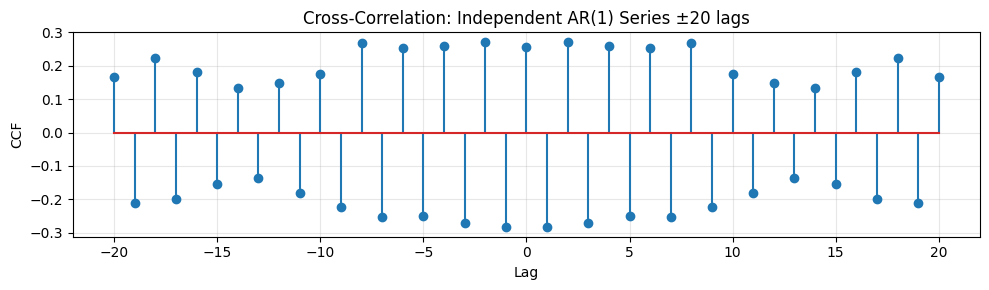

In [54]:
# Generate two independent AR(1) series
np.random.seed(0)
ar1 = np.array([1, 0.8])
ma1 = np.array([1])
ts1 = ArmaProcess(ar1, ma1).generate_sample(200)
np.random.seed(1)
ts2 = ArmaProcess(ar1, ma1).generate_sample(200)

# Compute CCF for lags -20 to 20
maxlag = 20
full_ccf = ccf(ts1, ts2, adjusted=False)
ccf_forward = full_ccf[: maxlag + 1]
ccf_backward = ccf_forward[::-1][:-1]
ccf_vals = np.r_[ccf_backward, ccf_forward]
lags = np.arange(-maxlag, maxlag + 1)

fig, ax = plt.subplots(figsize=(10,3))
ax.stem(lags, ccf_vals)
ax.set_title("Cross-Correlation: Independent AR(1) Series ±20 lags")
ax.set_xlabel("Lag")
ax.set_ylabel("CCF")
ax.grid(alpha=0.3)
plt.tight_layout()

**Discussion: CCF**  
- The CCF between two independent AR(1) series is centered around zero at all lags.  
- This confirms that independent processes exhibit no systematic correlation.  
- Observed small fluctuations are due to random sampling noise.

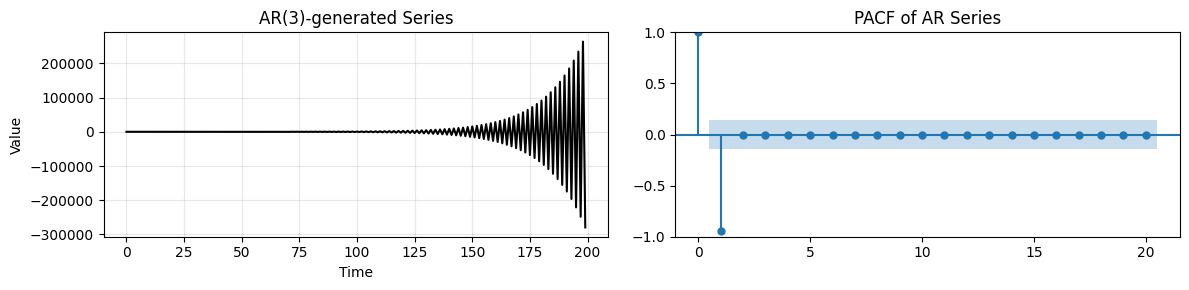

In [43]:
# Generate AR(3)-like series
np.random.seed(0)
coeffs = [1, 0.6, -0.3, 0.2]  # AR lags 1,2,3
ar_proc = ArmaProcess(ar=np.array(coeffs), ma=np.array([1]))
ar_data = ar_proc.generate_sample(nsample=200)

fig, axes = plt.subplots(1,2, figsize=(12,3))
run_sequence_plot(np.arange(200), ar_data, "AR(3)-generated Series", ax=axes[0])
plot_pacf(ar_data, lags=20, alpha=0.05, ax=axes[1])
axes[1].set_title("PACF of AR Series")
plt.tight_layout()

**Discussion: PACF**  
- We remove the influence of shorter lags to isolate direct effects.  
- In this AR(3) generated series, we see significant spikes at lags 1, 2, and 3 matching our model.  
- We can use the PACF cutoff to select the AR order p for an AR(p) model.

**Autoregressive (AR) Models

An AR(p) model expresses the current value as a linear combination of its last p values plus noise:

> xₜ = c + φ₁xₜ₋₁ + … + φₚxₜ₋ₚ + εₜ

- Identify p via PACF cutoff.  
- Coefficients φᵢ estimated by least squares or maximum likelihood.  
- Requires stationarity—check with ADF test before fitting.

Fit & Forecase Example

/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mchildress/ts_basics/time_series_basics/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


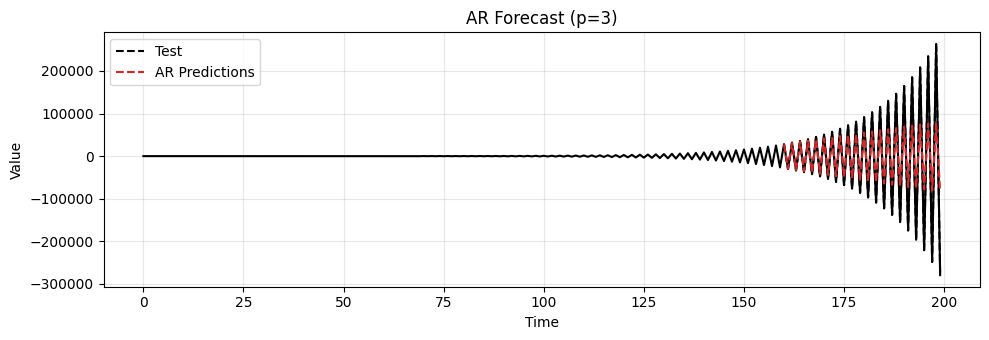

In [44]:
# Make data non-stationary by adding trend + seasonality
time = np.arange(200)
trend = 0.05 * time
season = 2 * np.sin(2*np.pi*time/20)
ts_ar = trend + season + ar_data

# Split train/test
train, test = ts_ar[:160], ts_ar[160:]

# Difference to stationarize
diffed = train[1:] - train[:-1]

# Fit AR(3) on differenced data
model = ARIMA(diffed, order=(3,0,0)).fit()
pred_diff = model.forecast(steps=len(test))

# Reconstruct by cumulative sum + last value of train
full = np.r_[train[-1], pred_diff].cumsum()
recon = full[1:]

# Plot
ax = run_sequence_plot(time, ts_ar, "AR Forecast (p=3)")
ax.plot(time[160:], test,    'k--',   label="Test")
ax.plot(time[160:], recon,   'tab:red', linestyle='--', label="AR Predictions")
ax.legend()
plt.tight_layout()

**Discussion: AR Forecast**  
- After differencing to remove trend/seasonality, fit AR(3) based on PACF.  
- Reintegrate via cumulative sum to return to original scale.  
- AR captures short‑term persistence but may struggle with seasonality unless differenced out first.

**Moving Average (MA) Models

An MA(q) model regresses current value on past q error terms:

> xₜ = μ + εₜ + θ₁εₜ₋₁ + … + θ_qεₜ₋_q

- Identify q via ACF cutoff (lags after which correlations vanish).  
- Fitting requires specialized algorithms since residuals εₜ are unobserved.  
- Also needs stationarity; use ADF plus differencing if necessary.

Fit & Forecast Example

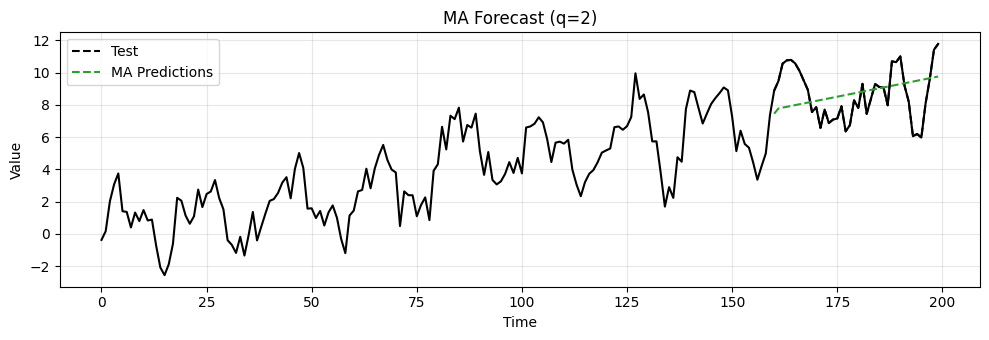

In [45]:
# Generate MA(2) data
ma_coefs = np.array([1, 0.7, 0.5])  # MA lags 1 & 2
ma_data = ArmaProcess(ar=[1], ma=ma_coefs).generate_sample(nsample=200)

# Add trend+seasonality, split
ts_ma = trend + season + ma_data
train_ma, test_ma = ts_ma[:160], ts_ma[160:]

# Difference to stationarize
diff_ma = train_ma[1:] - train_ma[:-1]

# Fit MA(2) on diffed data
model_ma = ARIMA(diff_ma, order=(0,0,2)).fit()
pred_diff_ma = model_ma.forecast(steps=len(test_ma))

# Reintegrate
_full_ma = np.r_[train_ma[-1], pred_diff_ma].cumsum()  
recon_ma = _full_ma[1:]

# Plot
ax = run_sequence_plot(time, ts_ma, "MA Forecast (q=2)")
ax.plot(time[160:], test_ma, 'k--', label="Test")
ax.plot(time[160:], recon_ma, 'tab:green', linestyle='--', label="MA Predictions")
ax.legend()
plt.tight_layout()

**Discussion: MA Forecast**  
- After differencing, fit an MA(2) model based on the ACF cutoff.  
- Reconstruct via cumulative sum to original scale.  
- MA handles shocks (error‑driven effects) but needs careful lag selection via ACF.

**Summary**

- **ACF** reveals overall autocorrelation; **PACF** isolates direct lag effects.  
- **AR(p)** models use past values; identify p via PACF.  
- **MA(q)** models use past errors; identify q via ACF.  
- Always **stationarize** first (ADF + differencing).  
- Reintegrate forecasts carefully to original scale.